In [ ]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.1/547.1 kB 9.3 MB/s eta 0:00:00


In [ ]:
import shap
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
import xgboost
from balance_dataset import balance_dataset
import pandas as pd
from statistics import mean, stdev
from sklearn.preprocessing import StandardScaler

In [ ]:
def create_handcraft_features(data):
    # mean value of activity for every 30 mins
    means = []

    # activity for every 30 min of a whole day
    max_activity = []
    min_activity = []
    stds = []

    # patient's id
    p_id = []

    data2 = pd.DataFrame()
    personal_data = pd.read_csv('Data/scores_for classification_2.csv')

    activity_list = []
    for i in range(0, len(data)):
        activity_list.append(data.iloc[i]["activity"])
        if ((i - 1) % 48 == 0 and i != 0):
            means.append(mean(activity_list))
            stds.append(stdev(activity_list))
            max_activity.append(max(activity_list))
            min_activity.append(min(activity_list))
            p_id.append(data.iloc[i]["patient"])
            activity_list = []

    data2["means"] = means
    data2["stds"] = stds
    data2["max"] = max_activity
    data2["min"] = min_activity
    data2["patient"] = p_id

    age = []
    gender = []
    target = []
    inpatient = []
    edu = []
    marriage = []
    work = []

    for i in range(0, len(data2)):
        patient_id = int(data2.iloc[i]["patient"])
        age.append(personal_data.iloc[patient_id - 1]["age"]-1)
        gender.append(personal_data.iloc[patient_id - 1]["gender"]-1)
        target.append(personal_data.iloc[patient_id - 1]["afftype"]%2)
        inpatient.append(personal_data.iloc[patient_id - 1]["inpatient"]-1)
        edu.append(personal_data.iloc[patient_id - 1]["edu"]-1)
        marriage.append(personal_data.iloc[patient_id - 1]["marriage"]-1)
        work.append(personal_data.iloc[patient_id - 1]["work"]-1)

    data2["age"] = age
    data2["gender"] = gender
    data2["target"] = target
    data2["inpatient"] = inpatient
    data2["edu"] = edu
    data2["marriage"] = marriage
    data2["work"] = work

    return data2


analytic_train = pd.read_csv('Data/train2.csv')
analytic_test = pd.read_csv('Data/test2.csv')
analytic_validation = pd.read_csv("Data/validation2.csv")

df_train = create_handcraft_features(analytic_train)
df_test = create_handcraft_features(analytic_test)
df_validation = create_handcraft_features(analytic_validation)

# balance the dataset
df_train = balance_dataset(df_train)
df_test = balance_dataset(df_test)
df_validation = balance_dataset(df_validation)

# split to features and targets
X_train = df_train.drop(['target'], axis=1).drop(['patient'], axis=1)
y = df_train['target']
X_test = df_test.drop(['target'], axis=1).drop(['patient'], axis=1)
y_test = df_test['target']
cols_to_scale = ['means','stds','min','max']
scaler = StandardScaler()
X = X_train
X[cols_to_scale] = scaler.fit_transform(X_train[cols_to_scale])
# X = pd.DataFrame(X, index=X_train.index, columns=X_train.columns)
X_test_scaled = X_test
X_test_scaled[cols_to_scale] = scaler.transform(X_test[cols_to_scale])
# X_test = pd.DataFrame(X_test_scaled, index=X_test.index, columns=X_test.columns)

In [ ]:
# train XGBoost model
model = xgboost.XGBClassifier(learning_rate=0.05, n_estimators=600, objective='binary:logistic',
                              nthread=1, max_depth=2, min_child_weight=2, gamma=0.3, colsample_bytree=1.0,
                              subsample=1, random_state=2023)

In [ ]:
model.fit(X, y)

# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 84.65%


In [ ]:
def f(x):
    return shap.links.identity(model.predict_proba(x, validate_features=False)[:,1])

# explain the model's predictions using SHAP values
masker = shap.maskers.Independent(data = X)
explainer = shap.Explainer(f, masker = masker)
shap_values = explainer(X)

Exact explainer: 163it [00:14,  3.41it/s]                         


In [ ]:
y[0]

0.0

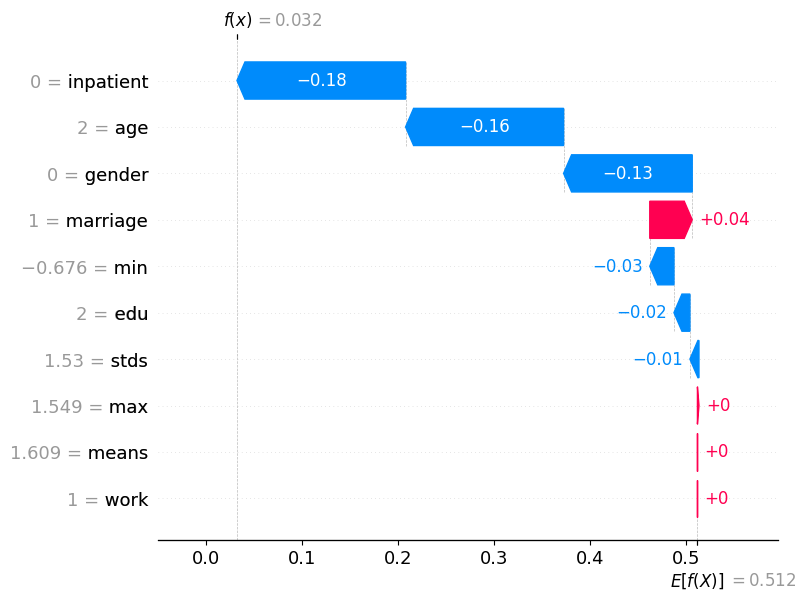

In [ ]:
# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[0])

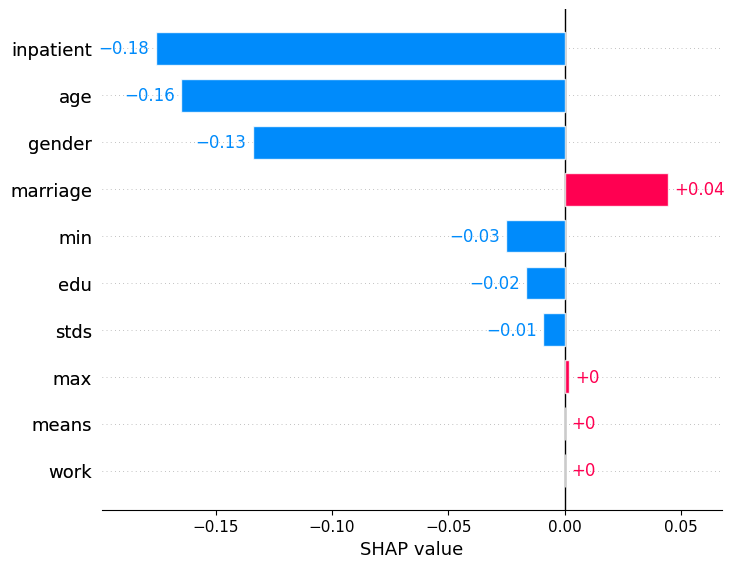

In [ ]:
# plot the global importance of each feature
shap.plots.bar(shap_values[0])

In [ ]:
shap.plots.initjs()

# visualize the first prediction's explanation
shap.plots.force(shap_values[0])

In [ ]:
shap.plots.initjs()

# visualize the first prediction's explanation
shap.plots.force(shap_values)

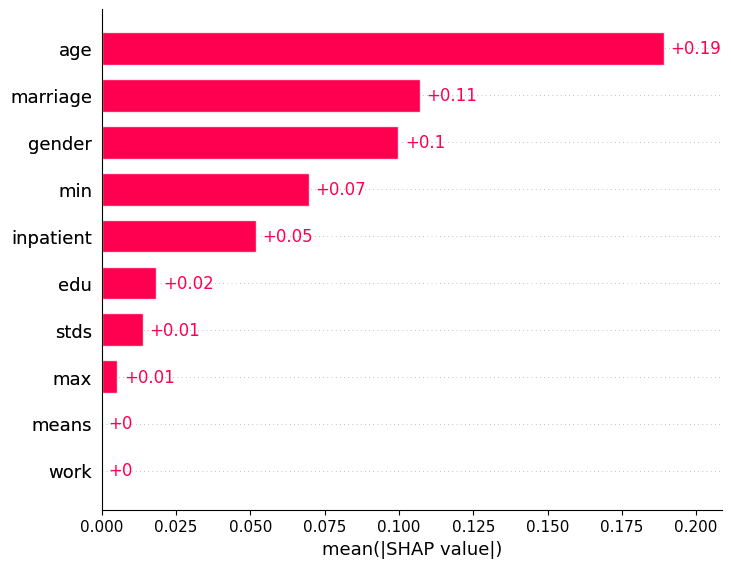

In [ ]:
# plot the global importance of each feature
shap.plots.bar(shap_values)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


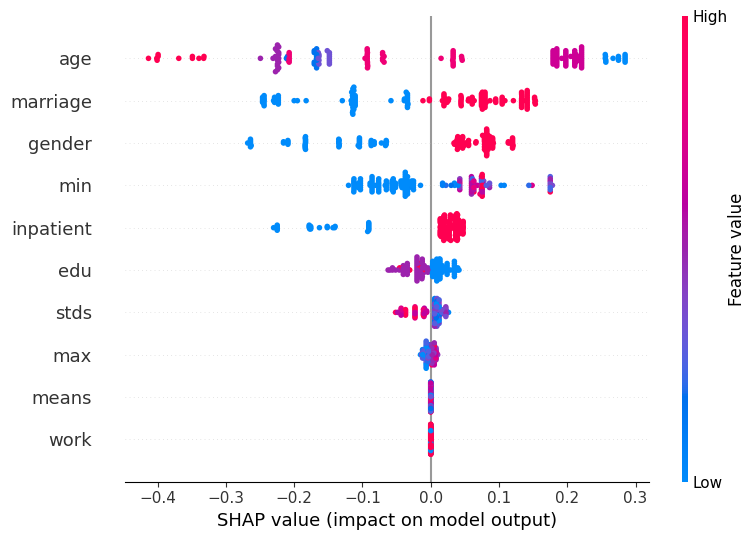

In [ ]:
# plot the distribution of importances for each feature over all samples
shap.summary_plot(shap_values, X)